In [5]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from environnement.atmosphere import AtmosphereISA

#### Data manager (truc compliqué pas forcément nécessaire)

In [6]:
# Data_manager class
# The class is used to manage the data from the simulation
# Simply store data in a dictionary
class DataManager():
    # Initialize the data manager with the given data
    def __init__(self, **kw) -> None:
        self.datas = {}
        for key, value in kw.items():
            self.datas[key] = [value]
    
    # Add data to the data manager
    def add(self, **kw):
        for key, value in kw.items():
            self.datas[key].append(value)

    # Get the data from the data manager
    def get(self, key): 
        return self.datas[key]       

    # Get the data as an array
    def get_array(self, key):
        return np.array(self.datas[key])
    

#### Spacecraft thermal behavior

Minimum temperature inside:  -22.243780029493593 °C


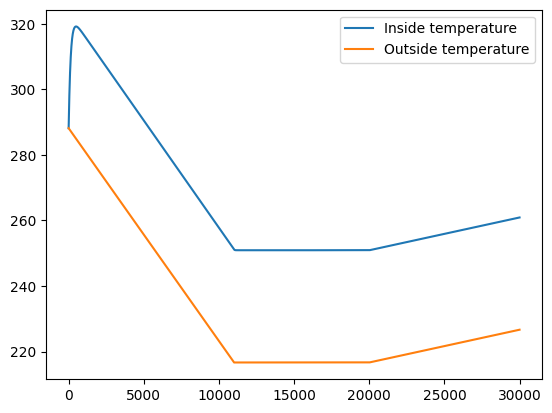

In [7]:
# =====================================================================
# ============================ Paramètrage ============================
# =====================================================================

# =========================== Constantes ==========================
R = 8.314                                       # Ideal gas constant in J/(mol.K)
M = 0.028964                                    # Molar mass of air in kg/mol
g = 9.81                                        # Gravitational acceleration in m/s^2
cm_air = 4186                                   # Specific heat of air in J/(kg.K)

# Atmosphere object
atm = AtmosphereISA()                              # Atmosphere object


# ======================== Spacecraft config ======================
# Box parameters (dans l'absolu il serait plus lisible de direct calculer les surfaces et volumes)
box_width = 15e-2                               # Box width in m
box_height = 15e-2                              # Box height in m
box_length = 20e-2                              # Box length in m
insulation_width = 2e-2                         # Insulation width in m
inner_volume = (box_width - 2*insulation_width)*(box_height - 2*insulation_width)*(box_length - 2*insulation_width) # Inner volume in m^3
inner_surface = 2 * ((box_width - insulation_width)*(box_height - insulation_width)+(box_length - insulation_width)*(box_width-insulation_width)+(box_length - insulation_width) * (box_height-insulation_width)) # Inner surface in m^2
outter_surface = 2 * (box_width * box_height + box_width * box_length + box_height * box_length) # Outter surface in m^2
S = 4 * 15 * 20 * 10**-4 + 2 * 20**2 * 10**-4   # Outter surface in m^2

# Ascension parameters
alt = 0                                         # Altitude in m
ascension_rate = 2                              # Ascension rate in m/s


# ===================== Paramètres thermiques =====================
T0 = atm.get_temperature(alt)                   # Initial temperature in Kelvin
T_in = T0                                       # Temperature in Kelvin

# Insulation properties
# Inside convection
h_in = 5                                        # Inside convection coefficient in W/(m^2.K)
Rth_in = 1 / (h_in * inner_surface)             # Thermal resistance in K/W (inside convection)

# Polystyrene layer
e = insulation_width                            # Insulation width in m
lmbda = 0.035                                   # Coefficient of heat transfer in W/(m^2.K) (polystyrene)
Rth_ins = e / (lmbda * outter_surface)          # Thermal resistance in K/W (polystyrene)

# Air layer
e = 5e-3                                        # Air layer width in m
lmbda = 0.025                                   # Coefficient of heat transfer in W/(m^2.K) (air)
Rth_air = e / (lmbda * outter_surface)          # Thermal resistance in K/W (air)

# Outside convection
h = 10                                          # Outside convection coefficient in W/(m^2.K)
Rth_out = 1 / (h * outter_surface)              # Thermal resistance in K/W (outside convection)

Rtot = Rth_in + Rth_ins + Rth_air + Rth_out     # Total thermal resistance in K/W

# Solar and IR fluxes
Pss = 1361                                      # Solar flux in W/m^2
Pst = 240                                       # IR Flux from the Earth in W/m^2
albedo = 0.3                                    # Albedo of the Earth
P_sun = Pss * outter_surface / 2                # Solar power received by the craft in W (assumed that the surface lit by the sun is half of the outter surface)(optimist)
P_earth = Pst * outter_surface / 2              # Earth IR power received by the craft in W (assumed that the surface lit by the Earth is half of the outter surface)(optimist)

# Il faudra ajouter un calcul ou valeur numérique du coeffiction d'absorption de la boîte

# Active heating parameters
P_heating = 5                                   # Heating power in W


# ===================== Simulation parameters ========================
step = 0.1                                      # Time step in seconds
time = 0                                        # Time in seconds (not used)

# List to be recorded
datamng = DataManager(alt = alt, T_in=T0, T_out=atm.get_temperature(alt), P=atm.get_pressure(alt), rho=atm.get_density(alt), air_mass=atm.get_density(alt) * inner_volume, time=0)


# =====================================================================
# ============================ Simulation ============================
# =====================================================================

# Simulating the temperature evolution in the box for a linear rise in the atmosphere
# Dans l'ordre :
# - On augmente l'altitude
# - On récupère les propriétés de l'atmosphère à cette altitude
# - On calcule la masse d'air dans la boîte
# - On met à jour la température
# - On sauvegarde les données
while alt < 30000:
    # Increase altitude
    alt = alt + ascension_rate * step

    # Recover atmosphere properties at given altitude
    _P = atm.get_pressure(alt)
    _T_out = atm.get_temperature(alt)
    _rho = atm.get_density(alt)

    # Get the air mass in the box and update the temperature
    _air_mass = _rho * inner_volume
    _condconvFlux = - (T_in - _T_out) / Rtot
    T_in = T_in + ((_condconvFlux + P_heating) * step) / (cm_air * _air_mass)

    # Save data
    datamng.add(alt = alt, T_in=T_in, T_out=_T_out, P=_P, rho=_rho, air_mass=_air_mass, time=datamng.get('time')[-1] + step)


# =====================================================================
# ============================ Processing ============================
# =====================================================================

# Data process
print("Minimum temperature inside: ", min(datamng.get('T_in'))-273.15, "°C")

# Plot the temperature evolution
plt.plot(datamng.get('alt'), datamng.get('T_in'), label='Inside temperature')
plt.plot(datamng.get('alt'), datamng.get('T_out'), label='Outside temperature')
plt.legend()

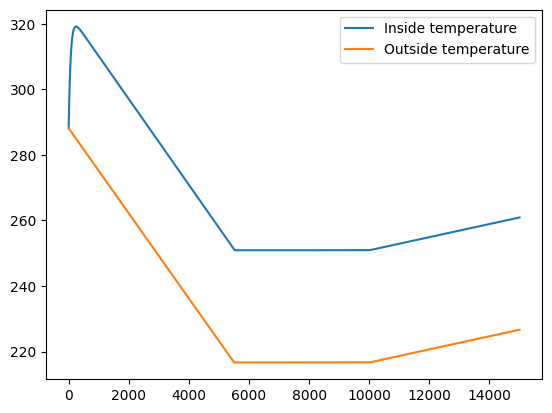

In [8]:
plt.plot(datamng.get('time'), datamng.get('T_in'), label='Inside temperature')
plt.plot(datamng.get('time'), datamng.get('T_out'), label='Outside temperature')
plt.legend()